# Cahn-Hilliard Equation 

Here we solve the [Cahn-Hilliard equation](https://www.math.purdue.edu/~shen7/pub/ac_ch.pdf)
\begin{cases}
    \partial_t u - \Delta \left[\frac{1}{\epsilon^2} f(u) - \Delta u\right] = 0, & (x,t) \in \Omega \times (0,T] \\ 
    \partial_n \left[\Delta u - \frac{1}{\epsilon^2} f(u)\right] = 0, & (x,t) \in \partial \Omega \times (0,T] \\
    \partial_n u = 0, & (x,t) \in \partial \Omega \times (0,T] \\
    u = u_0, & (x,t) \in \Omega \times \{0\}
\end{cases}
where $\epsilon$ is constant, $\Delta$ is the Laplacian, $n$ is the outward normal, and $f(u) = F'(u)$ for a given energy potential $F(u)$. Notice that $\partial_n \left[\Delta u - \frac{1}{\epsilon^2} f(u)\right] = \partial_n \Delta u - \frac{1}{\epsilon^2} f'(u) \partial_n u$ and $\partial_n u = 0$ for $x \in \partial \Omega$, so the second equation simplifies to $\partial_n \Delta u = 0$.

We use $F(u) = (u^2-3)^2/4$ so $f(u) = u^3-3u$ with $f'(u) = 3(u-1)$ and $f''(u) = 3$ which gives
$$\Delta f(u) = f''(u) \lVert \nabla u \rVert_2^2 + f'(u) \Delta u = 3 \lVert \nabla u \rVert_2^2 + 3(u-1) \Delta u.$$
Moreover, we will consider $\Omega = [0,1]^2$ so that for $x \in \partial \Omega$ we either have $x_1 \in \{0,1\}$ for which $\partial_n = \partial_{x_1}$ or we have $x_2 \in \{0,1\}$ for which $\partial_n = \partial_{x_2}$. We may therefore write the PDE as 
\begin{cases}
    \left[\partial_t u + \Delta^2 u\right] - \frac{3}{\epsilon^2}\left[\lVert \nabla u \rVert_2^2 + (u-1) \Delta u\right] = 0, & x \in [0,1]^2,t \in (0,T]  \\ 
    \partial_{x_1} \Delta u = 0, & x_1 \in \{0,1\}, x_2 \in [0,1], t \in (0,T] \\
    \partial_{x_1} u = 0, & x_1 \in \{0,1\}, x_2 \in [0,1], t \in (0,T] \\
    \partial_{x_2} \Delta u = 0, & x_1 \in [0,1], x_2 \in \{0,1\}, t \in (0,T] \\ 
    \partial_{x_2} u = 0, & x_1 \in [0,1], x_2 \in \{0,1\}, t \in (0,T] \\
    u = u_0, & (x,t) \in \Omega \times \{0\}
\end{cases}

In [1]:
import qmcpy as qp 
import numpy as np 
import torch
import time
from collections import OrderedDict
import scipy.fftpack
import h5py

In [2]:
from matplotlib import pyplot,cm,colors,gridspec
pyplot.style.use('seaborn-whitegrid')
LW = 3 # linewidth

## PDE Setup

In [3]:
EPSILON = 0.005

In [15]:
llbetas = [ # derivative orders 
    # interior
    [
        torch.tensor([[0,0,0]],dtype=int), # u
        torch.tensor([[0,2,0],[0,0,2]],dtype=int), # laplacian u
        torch.tensor([[0,1,0]],dtype=int), # partial_{x_1} u
        torch.tensor([[0,0,1]],dtype=int), # partial_{x_2} u
        torch.tensor([[1,0,0],[0,4,0],[0,2,2],[0,0,4]],dtype=int), # partial_t x + laplacian^2 u 
    ],
    # left-right boundary i.e. x_1 = 0 or x_1 = 1
    
    [
        torch.tensor([[0,3,0],[0,1,2]],dtype=int) # partial_{x_1} laplacian u
    ],
    [ 
        torch.tensor([[0,1,0]],dtype=int) # partial_{x_1} u
    ],
    # top-bottom boundary i.e. x_2 = 0 or x_2 = 1
    [
        torch.tensor([[0,2,1],[0,0,3]],dtype=int) # partial_{x_2} laplacian u
    ],
    [
        torch.tensor([[0,0,1]],dtype=int) # partial_{x_2} u
    ],
    
    # initial condition i.e. t=0
    [
        torch.tensor([[0,0,0]],dtype=int) # u
    ],
]
llcs = [ # summand of derivatives coefficients
    # interior
    [
        torch.ones(1,dtype=float), # u 
        torch.ones(2,dtype=float), # laplacian u
        torch.ones(1,dtype=float), # partial_{x_1} u
        torch.ones(1,dtype=float), # partial_{x_2} u
        torch.tensor([1,1,2,1],dtype=int), # partial_t x + laplacian^2 u 
    ],
    # left-right boundary i.e. x_1 = 0 or x_1 = 1
    [ 
        torch.ones(2,dtype=float) # partial_{x_1} u
    ],
    [
        torch.ones(1,dtype=float) # partial_{x_1} laplacian u
    ],
    # top-bottom boundary i.e. x_2 = 0 or x_2 = 1
    [
        torch.ones(2,dtype=float) # partial_{x_2} u
    ],
    [
        torch.ones(1,dtype=float) # partial_{x_2} laplacian u
    ],
    # initial condition i.e. t=0
    [
        torch.ones(1,dtype=float) # u
    ],
]

## Reference Solver

In [9]:
dt = 0.000001
maxiter = 2001
N_1,N_2 = 128,128
x1right,x2right = 1,1
t = np.linspace(0, dt * maxiter + dt, maxiter)
T = t[-1]
x1 = np.linspace(0.5 * x1right / N_1, x1right - 0.5 * x1right / N_1, N_1)
x2 = np.linspace(0.5 * x2right / N_2, x2right - 0.5 * x2right / N_2, N_2)
tmesh,x1mesh,x2mesh = np.meshgrid(t,x1,x2,indexing="ij")
ticks = np.vstack([tmesh.flatten(),x1mesh.flatten(),x2mesh.flatten()]).T
print("ticks.shape = %s"%str(tuple(ticks.shape)))
x1mesh0,x2mesh0 = np.meshgrid(x1,x2) 
ticks0 = np.vstack([np.zeros(N_1*N_2),x1mesh0.flatten(),x2mesh0.flatten()]).T
print("ticks0.shape = %s"%str(tuple(ticks0.shape)))
print("log2(len(ticks)) = %.1f"%np.log2(len(ticks)))

ticks.shape = (32784384, 3)
ticks0.shape = (16384, 3)
log2(len(ticks)) = 25.0


In [10]:
# fig = pyplot.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(ticks[:,0],ticks[:,1],ticks[:,2],s=.001)
# ax.scatter(ticks0[:,0],ticks0[:,1],ticks0[:,2],s=.01)
# ax.set_xlabel(r"$t$"); ax.set_ylabel(r"$x_1$"); ax.set_zlabel(r"$x_2$")
# ax.set_xlim([0,T]); ax.set_ylim([0,x1right]); ax.set_zlim([0,x2right]);

In [11]:
rng = np.random.Generator(np.random.SFC64(seed=None))
u0_ic = 2*rng.integers(low=0,high=2,size=(N_1,N_2))-1 # independent uniforms over {-1,1}
print("u0_ic.shape = %s with unique values %s"%(u0_ic.shape,np.unique(u0_ic)))
import scipy.interpolate
u0_ic_interp_nn = scipy.interpolate.NearestNDInterpolator(ticks0[:,1:],u0_ic.flatten())

u0_ic.shape = (128, 128) with unique values [-1  1]


In [12]:
def dct2(a):

    return scipy.fftpack.dct(scipy.fftpack.dct(a, axis = 0, norm = 'ortho'), axis = 1, norm = 'ortho' )

def idct2(a):

    return scipy.fftpack.idct(scipy.fftpack.idct(a, axis = 0 , norm = 'ortho'), axis = 1 , norm = 'ortho')

def f(a):

    return a ** 3 - 3 * a

def full_update(Uold, N_1, N_2, dt, Leig, CHeig):

    fU = f(Uold)
    hat_U = dct2(np.real(Uold.reshape(N_1, N_2))).reshape((N_1 * N_2,))
    Df = dct2(np.real(fU.reshape(N_1, N_2)) ).reshape((N_1 * N_2,)) # The alternative is to build the corresponding (N_2*N_1,N_2*N_1) 2d DCT matrix via kronecker products
    hat_U = (hat_U + dt * Leig * Df) / CHeig
    Unew = idct2(hat_U.reshape((N_1, N_2))).reshape((N_1 * N_2,))

    return Unew

def solver(U_init):
    xp = np.linspace(0, (N_1 - 1) / x1right, N_1)
    yq = np.linspace(0, (N_2 - 1) / x2right, N_2)
    Leig = -(np.tile((xp ** 2), (N_2, 1)).T + np.tile(yq ** 2,(N_1, 1))) * (np.pi ** 2)     #(N_1,N_2)
    CHeig = np.ones((N_1, N_2)) - 2 * dt * Leig + dt * (EPSILON ** 2) * (Leig ** 2)

    #Reshaping into vectors
    Leig = Leig.reshape((N_1 * N_2,))
    CHeig = CHeig.reshape((N_1 * N_2,))

    U = np.zeros([maxiter, N_1 * N_2])
    U[0, :] = U_init

    for ii in range(maxiter - 1):
        U[ii + 1, :] = full_update(U[ii, :], N_1, N_2, dt, Leig, CHeig)

    return U

u_ref = solver(u0_ic.flatten()).reshape(maxiter,N_1,N_2)
print("u_ref.shape: %s"%str(u_ref.shape))

u_ref.shape: (2001, 128, 128)


## Kernel Interpolant 

### Construction

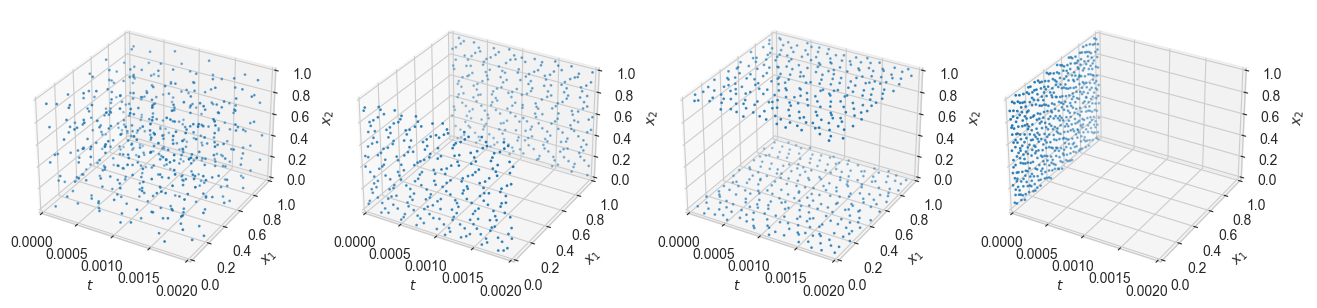

In [18]:
n = 2**9
dd_obj = qp.DigitalNetB2(dimension=3,seed=7)
x_i = torch.from_numpy(dd_obj.gen_samples(n))
x_i = x_i*torch.tensor([T,x1right,x2right])
x_bcx1 = x_i.clone(); x_bcx1[:n//2,1] = 0; x_bcx1[n//2:,1] = 1
x_bcx2 = x_i.clone(); x_bcx2[:n//2,2] = 0; x_bcx2[n//2:,2] = 1
x_ic = x_i.clone(); x_ic[:,0] = 0
x_geoms = [x_i,x_bcx1,x_bcx2,x_ic]
fig,ax = pyplot.subplots(nrows=1,ncols=len(x_geoms),figsize=(len(x_geoms)*4,4),subplot_kw={'projection': '3d'})
for i,x_geom in enumerate(x_geoms):
    ax[i].scatter(x_geom[:,0],x_geom[:,1],x_geom[:,2],s=1)
    ax[i].set_xlabel(r"$t$"); ax[i].set_ylabel(r"$x_1$"); ax[i].set_zlabel(r"$x_2$")
    ax[i].set_xlim([0,T]); ax[i].set_ylim([0,x1right]); ax[i].set_zlim([0,x2right])

In [231]:
from scipy.spatial.distance import pdist
pdist(t[:,None]).shape,2001**2

((2001000,), 4004001)

In [238]:
noise = 1e-12
md2s = np.array([
    ((t[:,None]-t[None,:])**2).mean(),
    ((x1[:,None]-x1[None,:])**2).mean(),
    ((x2[:,None]-x2[None,:])**2).mean()])
print(lengthscales)
kernel = qp.KernelGaussian(dimension=3,lengthscales=.1*torch.from_numpy(md2s),scale=1,torchify=True) # kernel
xs,ns,us = [x_i,x_bcx1,x_bcx1,x_bcx2,x_bcx2,x_ic],None,None
ki = qp.PDEGramMatrix(kernel,xs,ns,us,llbetas,llcs,noise,half_comp=half_comp) # kernel interpolant

[6.68668667e-07 1.66656494e-01 1.66656494e-01]


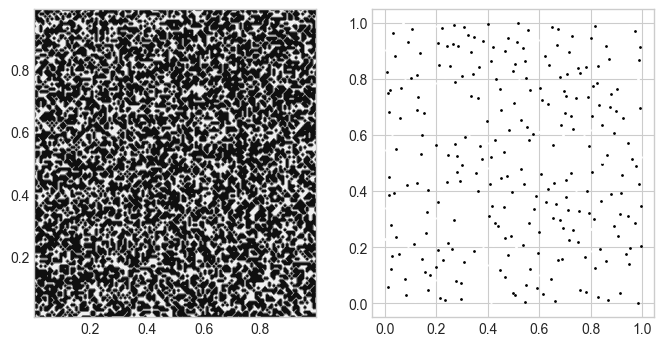

In [239]:
u0_ic_nn = torch.from_numpy(u0_ic_interp_nn(x_ic[:,1:].numpy()))
u0_ic_b = u0_ic.flatten()==1
u0_ic_nn_b = u0_ic_nn.flatten()==1
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(2*4,4))
ax[0].contourf(x1mesh0,x2mesh0,u0_ic,cmap=cm.binary)
ax[1].scatter(x_ic[u0_ic_nn_b,1],x_ic[u0_ic_nn_b,2],color="k",s=1)
ax[1].scatter(x_ic[~u0_ic_nn_b,1],x_ic[~u0_ic_nn_b,2],color="w",s=1)

### PDE Optimization

\begin{cases}
    \left[\partial_t u + \Delta^2 u\right] - \frac{3}{\epsilon^2}\left[\lVert \nabla u \rVert_2^2 + (u-1) \Delta u\right] = 0, & x \in [0,1]^2,t \in (0,T]  \\ 
    \partial_{x_1} \Delta u = 0, & x_1 \in \{0,1\}, x_2 \in [0,1], t \in (0,T] \\
    \partial_{x_1} u = 0, & x_1 \in \{0,1\}, x_2 \in [0,1], t \in (0,T] \\
    \partial_{x_2} \Delta u = 0, & x_1 \in [0,1], x_2 \in \{0,1\}, t \in (0,T] \\ 
    \partial_{x_2} u = 0, & x_1 \in [0,1], x_2 \in \{0,1\}, t \in (0,T] \\
    u = u_0, & (x,t) \in \Omega \times \{0\}
\end{cases}

In [240]:
def pde_lhs(ly_i, ly1_bcx1, ly2_bcx1, ly1_bcx2, ly2_bcx2, ly_ic):
    # first equation 
    u_i,laplace_u_i,partial_x1_u_i,partialx2_u_i,partialt_u_plus_laplace2_u_i = ly_i
    #lhs_i = partialt_u_plus_laplace2_u_i-3/EPSILON**2*(partial_x1_u_i**2+partialx2_u_i**2+(u_i-1)*laplace_u_i)
    lhs_i = partialt_u_plus_laplace2_u_i-3*EPSILON*(partial_x1_u_i**2+partialx2_u_i**2+(u_i-1)*laplace_u_i)
    # second equation
    partialx1_laplace_u_bcx1 = ly1_bcx1[0]
    lhs1_bcx1 = partialx1_laplace_u_bcx1
    # third equation
    partialx1_u_bcx1 = ly2_bcx1[0]
    lhs2_bcx1 = partialx1_u_bcx1
    # fourth equation 
    partialx2_laplace_u_bcx2 = ly1_bcx2[0]
    lhs1_bcx2 = partialx2_laplace_u_bcx2
    # fifth equation 
    partialx2_u_bcx2 = ly2_bcx2[0]
    lhs2_bcx2 = partialx2_u_bcx2
    # sixth equation
    u_ic = ly_ic[0]
    lhs_ic = u_ic 
    return lhs_i,lhs1_bcx1,lhs2_bcx1,lhs1_bcx2,lhs2_bcx2,lhs_ic 
def pde_rhs(x_i, x_bcx1_1, x_bcx1_2, x_bcx2_1,x_bcx2_2, x_ic):
    y_i = torch.zeros(len(x_i),dtype=float)
    y_bcx1_1 = torch.zeros(len(x_bcx1_1),dtype=float)
    y_bcx1_2 = torch.zeros(len(x_bcx1_2),dtype=float)
    y_bcx2_1 = torch.zeros(len(x_bcx2_1),dtype=float)
    y_bcx2_2 = torch.zeros(len(x_bcx2_2),dtype=float)
    y_ic = u0_ic_nn
    return y_i,y_bcx1_1,y_bcx1_2,y_bcx2_1,y_bcx2_2,y_ic

    iter (10 max)  loss           
    0              4.08e-01       
    1              3.22e+06       
    2              1.74e+04       
    3              2.20e+02       
    4              1.65e+00       
    5              4.23e-01       
    6              3.36e-01       
    7              3.60e-01       
    8              4.41e-01       
    9              2.53e-01       
    10             3.29e-01       
tensor([ -18.4897, -409.6230,  -67.5600,  ...,   -1.0000,   -1.0002,
           1.0000], dtype=torch.float64)


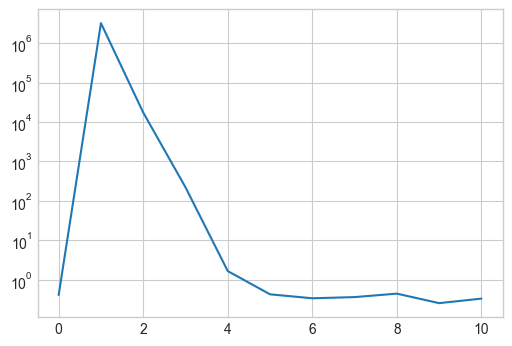

In [241]:
z,data = ki.pde_opt_gauss_newton(
    pde_lhs = pde_lhs,
    pde_rhs = pde_rhs,
    maxiter = 10,
    verbose = True)
z_use = data["zhist"][-1]
print(z_use)
data["losses"]
fig,ax = pyplot.subplots(figsize=(6,4))
ax.plot(data["losses"])
ax.set_yscale("log",base=10)

### Fitting

In [242]:
t_infer = t[::len(t)//4]
u_ref_infer = u_ref[::len(t)//4]
x1_infer = x1[::len(x1)//32]
x2_infer = x2[::len(x1)//32]
t_infer.shape,x1_infer.shape,x2_infer.shape
tmesh_infer,x1mesh_infer,x2mesh_infer = np.meshgrid(t_infer,x1_infer,x2_infer,indexing="ij")
ticks_infer = np.vstack([tmesh_infer.flatten(),x1mesh_infer.flatten(),x2mesh_infer.flatten()]).T
ticks_infer.shape

(5120, 3)

In [243]:
coeffs = ki._solve(z_use) 
kvec = ki.get_new_left_full_gram_matrix(torch.from_numpy(ticks_infer))
yhat_mesh = (kvec@coeffs).reshape(tmesh_infer.shape)
yhat_mesh_mins = yhat_mesh.flatten(1).min(1).values
yhat_mesh_maxs = yhat_mesh.flatten(1).max(1).values
print("yhat_mesh.shape: %s"%str(tuple(yhat_mesh.shape)))
print("yhat_mesh.min() = %s\nyhat_mesh.max() = %s"%(yhat_mesh_mins.numpy(),yhat_mesh_maxs.numpy()))

yhat_mesh.shape: (5, 32, 32)
yhat_mesh.min() = [ -299.81192732 -1165.41063473  -385.39086762   -98.51529058
   -44.31403399]
yhat_mesh.max() = [ 991.10547292 2625.39534675  211.57473068  112.5802268    91.36594304]


In [244]:
kvec0 = ki.get_new_left_full_gram_matrix(xs[-1])
yhat0 = kvec0@coeffs
yhat0[:10]

tensor([ 0.9990, -0.9955, -0.9997, -1.0000, -1.0008, -1.0017,  0.9984, -1.0005,
         1.0048, -0.9951], dtype=torch.float64)

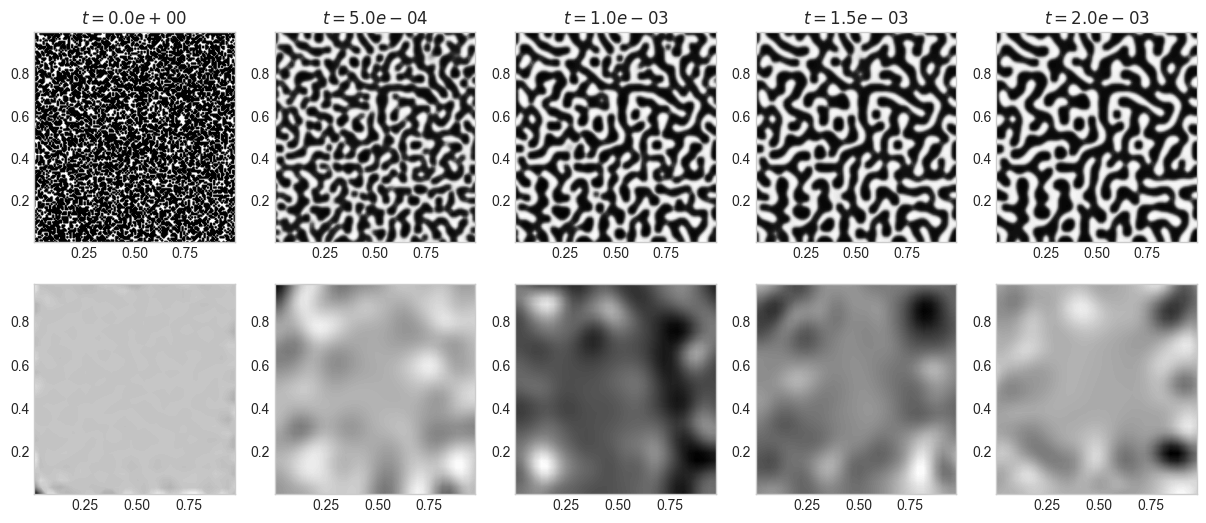

In [245]:
maxrows = fig,ax = pyplot.subplots(nrows=2,ncols=len(t_infer),figsize=(3*len(t_infer),3*2))
#ymin,ymax = ymesh.min(),ymesh.max()
for i in range(len(t_infer)):
    ax[0,i].set_title("$t = %.1e$"%t_infer[i])
    ax[0,i].contourf(x1mesh[i],x2mesh[i],u_ref_infer[i],antialiased=False,cmap=cm.binary, levels=100)
    ax[1,i].contourf(x1mesh_infer[i],x2mesh_infer[i],yhat_mesh[i],antialiased=False,cmap=cm.binary, levels=100)#, vmin=ymin, vmax=ymax)
    #ax[1,i].scatter(ticks0[:,1],ticks0[:,2],color=cm.binary(u_ref[i].flatten()))
    # ax[1,0].scatter(ki.xs[1][flag_u0_1,1],ki.xs[1][flag_u0_1,2],color="k",s=50)
    # ax[1,0].scatter(ki.xs[1][~flag_u0_1,1],ki.xs[1][~flag_u0_1,2],color="w",s=50);

6.686686673333333e-07